# 09. Clustering Grocery Items

In [62]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

In [5]:
from platform import python_version
print(python_version())

3.6.10


In [6]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px solid lightgray;
}

## Load Dataset

In [7]:
item_to_id=pd.read_csv('E:/Collection_DS_takehome_challenges/Data/grocery/item_to_id.csv')
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [9]:
item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [8]:
history=pd.read_csv('E:/Collection_DS_takehome_challenges/Data/grocery/purchase_history.csv')
history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [10]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


## Data Processing

In [15]:
def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index=list(range(1, 49)))

In [40]:
user_item_count = history.groupby('user_id').apply(id_to_item)
user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [42]:
user_item_count.reset_index()

,user_id,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,47,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
1,68,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,113,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,123,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,223,1,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24880,1499730,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
24881,1499778,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
24882,1499797,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,1
24883,1499817,1,2,0,0,0,1,0,1,1,...,0,0,0,2,1,2,1,0,1,1


## Question 1

### The customer who bought the most items overall in her lifetime

In [19]:
user_count = user_item_count.sum(axis=1).reset_index().rename(columns={0: 'count'})
user_count.sort_values(by='count', ascending=False).head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


So the customer who bought the most items is 269335 with 72 items

### For each item, the customer who bought that product the most

In [52]:
item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index()
item_user_most = item_user_most.rename(columns={'index': 'Item_id', 0: 'Index'})
df = pd.merge(left=item_user_most, right=item_to_id, on='Item_id', how='left')


df[['Item_id', 'Item_name', 'Index']]

,Item_id,Item_name,Index
0,1,sugar,512
1,2,lettuce,512
2,3,pet items,2552
3,4,baby items,92
4,5,waffles,3605
5,6,poultry,5555
6,7,sandwich bags,2926
7,8,butter,2493
8,9,soda,4445
9,10,carrots,10238


In [54]:
user_item_count.reset_index().iloc[item_user_most['Index'],0]

512        31625
512        31625
2552      154960
92          5289
3605      217277
5555      334664
2926      175865
2493      151926
4445      269335
10238     618914
6111      367872
9261      557904
10799     653800
2855      172120
2356      143741
1175       73071
6085      366155
15193     917199
512        31625
14623     885474
14597     884172
19892    1199670
15251     920002
3154      189913
1094       68282
16026     967573
15840     956666
3400      204624
6565      394348
375        21779
4803      289360
1771      109578
21668    1310207
5085      305916
7526      450482
4445      269335
749        46757
4231      255546
9918      599172
634        38872
2192      133355
1303       80215
16510     996380
512        31625
19857    1198106
20214    1218645
6419      384935
5575      335841
Name: user_id, dtype: int64

In [59]:
df['User_id']=user_item_count.reset_index().iloc[item_user_most['Index'],0].values
df[['Item_id', 'Item_name', 'User_id']]

,Item_id,Item_name,User_id
0,1,sugar,31625
1,2,lettuce,31625
2,3,pet items,154960
3,4,baby items,5289
4,5,waffles,217277
5,6,poultry,334664
6,7,sandwich bags,175865
7,8,butter,151926
8,9,soda,269335
9,10,carrots,618914


## Question 2

In [60]:
feature = user_item_count.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [61]:
clusters = range(2, 30)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_jobs=-1)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

D:\Anaconda3\envs\py36\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Anaconda3\envs\py36\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Anaconda3\envs\py36\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Anaconda3\envs\py36\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Anaconda3\envs\py36\lib\site-packages\sklearn\cluster\_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
D:\Anaconda3\envs\py36\li

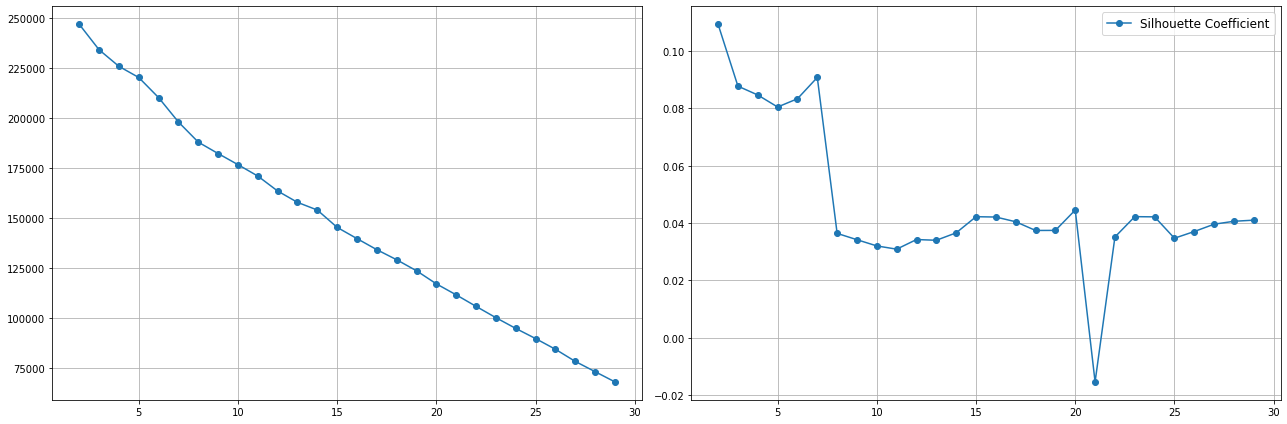

In [63]:
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

It seems 21 clusters is the best choice. Now, let's apply PCA on the data and visualize the data.

In [64]:
# build K-Means model
kmeans = KMeans(n_clusters=21, init='k-means++', random_state=42, n_jobs=-1)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [ ]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

In [66]:
print(pca_feature)

[[ 18.14562527  -2.48597703]
 [ 75.94301117 -31.47060996]
 [  3.3409709   -2.10547846]
 [-25.66783708  -2.35034891]
 [-29.6682334   -2.36844687]
 [ 15.49480874  -0.25936031]
 [-26.86062487  -2.36924791]
 [-11.70762808  -3.3094558 ]
 [ 17.43146206   5.01287113]
 [ 22.63158263 -25.18650308]
 [-29.9197811   -2.06185976]
 [-27.52948108  -3.81434678]
 [ 16.32144643  -5.40532067]
 [-11.87863922  -1.51945744]
 [-27.3297905   -2.74063296]
 [-10.91720149  -1.27353006]
 [ 15.01611238  -0.75966528]
 [ -8.14263215  -0.99204186]
 [-26.792324    -2.1621787 ]
 [ 19.77694458  40.23539582]
 [-12.08211186  -2.86282617]
 [ -8.18030376  -0.58813619]
 [ 16.40046741   3.51402868]
 [-26.22313607  -2.09088747]
 [ 20.30714798  38.83753863]
 [ -5.30021809  -1.38369501]
 [ -8.27702821   0.49183745]
 [ -5.50634096  -2.5225115 ]
 [-26.56592539  -3.08963875]
 [-30.16019024  -2.44799242]
 [-29.63209074  -2.33807465]
 [ 20.3204357   39.04838839]
 [-26.33174616  -1.94683286]
 [ 17.20841644  -3.88951952]
 [-27.40480239

In [69]:
print(label)

[ 1 10 16  4  4 12  0  4 14 17  4  4  2  4  0  4 12  4  4 15  4  4  8  0
 15  4  4  4  4  4  4 20  0 19  4  4 19  3 13  9  4  5 18  6  7 11 12  4]


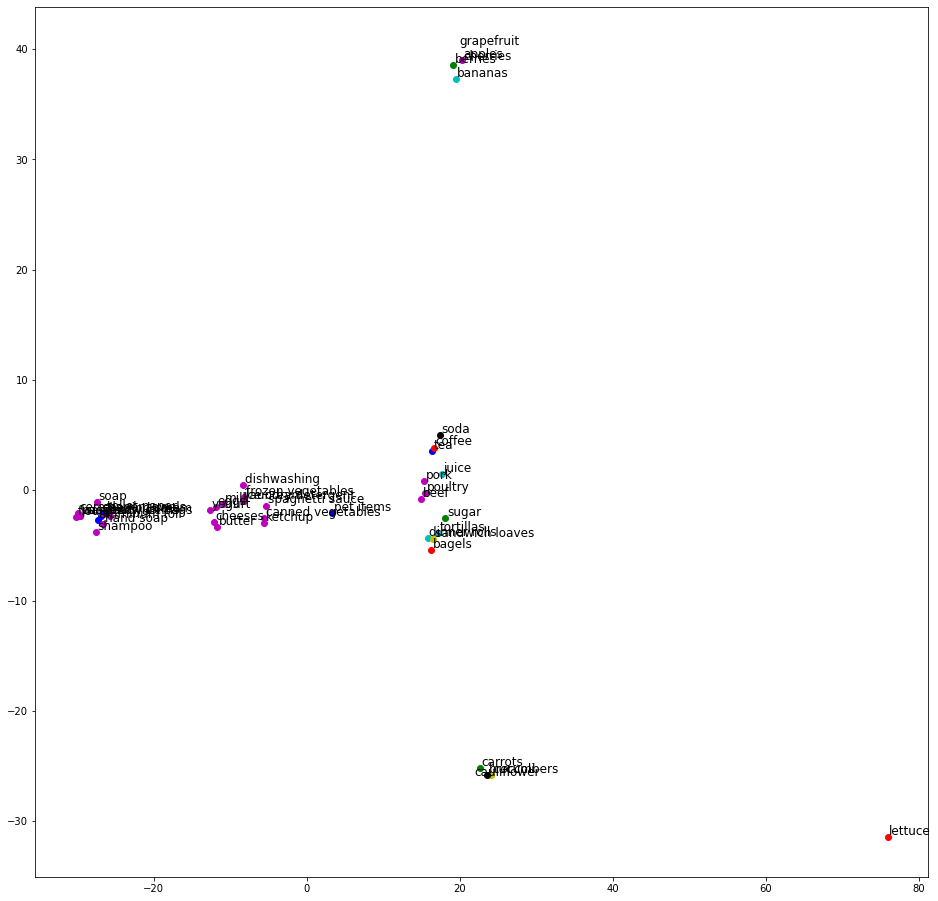

In [67]:
# visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0], fontsize=12)

plt.show()

In [70]:
# print useful information
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 21):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['sandwich bags', 'aluminum foil', 'paper towels', 'toilet paper']
1 	 ['sugar']
2 	 ['bagels']
3 	 ['juice']
4 	 ['baby items', 'waffles', 'butter', 'cereals', 'shampoo', 'eggs', 'milk', 'laundry detergent', 'shaving cream', 'cheeses', 'frozen vegetables', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'hand soap', 'flour', 'pasta', 'soap', 'ice cream', 'ketchup', 'yogurt']
5 	 ['cucumbers']
6 	 ['broccoli']
7 	 ['cauliflower']
8 	 ['tea']
9 	 ['berries']
10 	 ['lettuce']
11 	 ['bananas']
12 	 ['poultry', 'beef', 'pork']
13 	 ['sandwich loaves']
14 	 ['soda']
15 	 ['grapefruit', 'cherries']
16 	 ['pet items']
17 	 ['carrots']
18 	 ['coffee']
19 	 ['tortillas', 'dinner rolls']
20 	 ['apples']


Above clustering is based on the raw feature, namely the user purchase for each item. There are other methods for this problem. For example, this notebook contains another method: https://github.com/stasi009/TakeHomeDataChallenges/blob/master/09.ClusterGrocery/cluster_grocery.ipynb

With 21 clusters, some cluster looks very weird. Since there are only 48 different items, with one business expert in related area, it only take a few time to manually determine the best cluster numbers.